In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim 
from torchinfo import summary
import segmentation_models_pytorch as smp # PyTorch tabanlı segmentasyon modelleri için 'segmentation_models_pytorch' kütüphanesini içe aktar
from torchvision import transforms

import os
# Path
from pathlib import Path

# tqdm
from tqdm.auto import tqdm # İlerleme çubuğunu görselleştirmek için 'tqdm' kütüphanesini içe aktar
import random
import warnings
warnings.filterwarnings("ignore")
torch.cuda.empty_cache()


In [2]:
# Total Images
IMAGE_PATH = Path("tusimple_preprocessed2/training/frames")
IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*.jpg")) # dosya yolundaki tum png uzantili dosyalari listeler
IMAGE_PATH_LIST = sorted(IMAGE_PATH_LIST) 

print(f'Total Images = {len(IMAGE_PATH_LIST)}')


Total Images = 3626


In [3]:
MASK_PATH = Path("tusimple_preprocessed2/training/lane-masks")
MASK_PATH_LIST = list(MASK_PATH.glob("*.jpg"))
MASK_PATH_LIST = sorted(MASK_PATH_LIST)

print(f'Total Masks = {len(MASK_PATH_LIST)}')


Total Masks = 3626


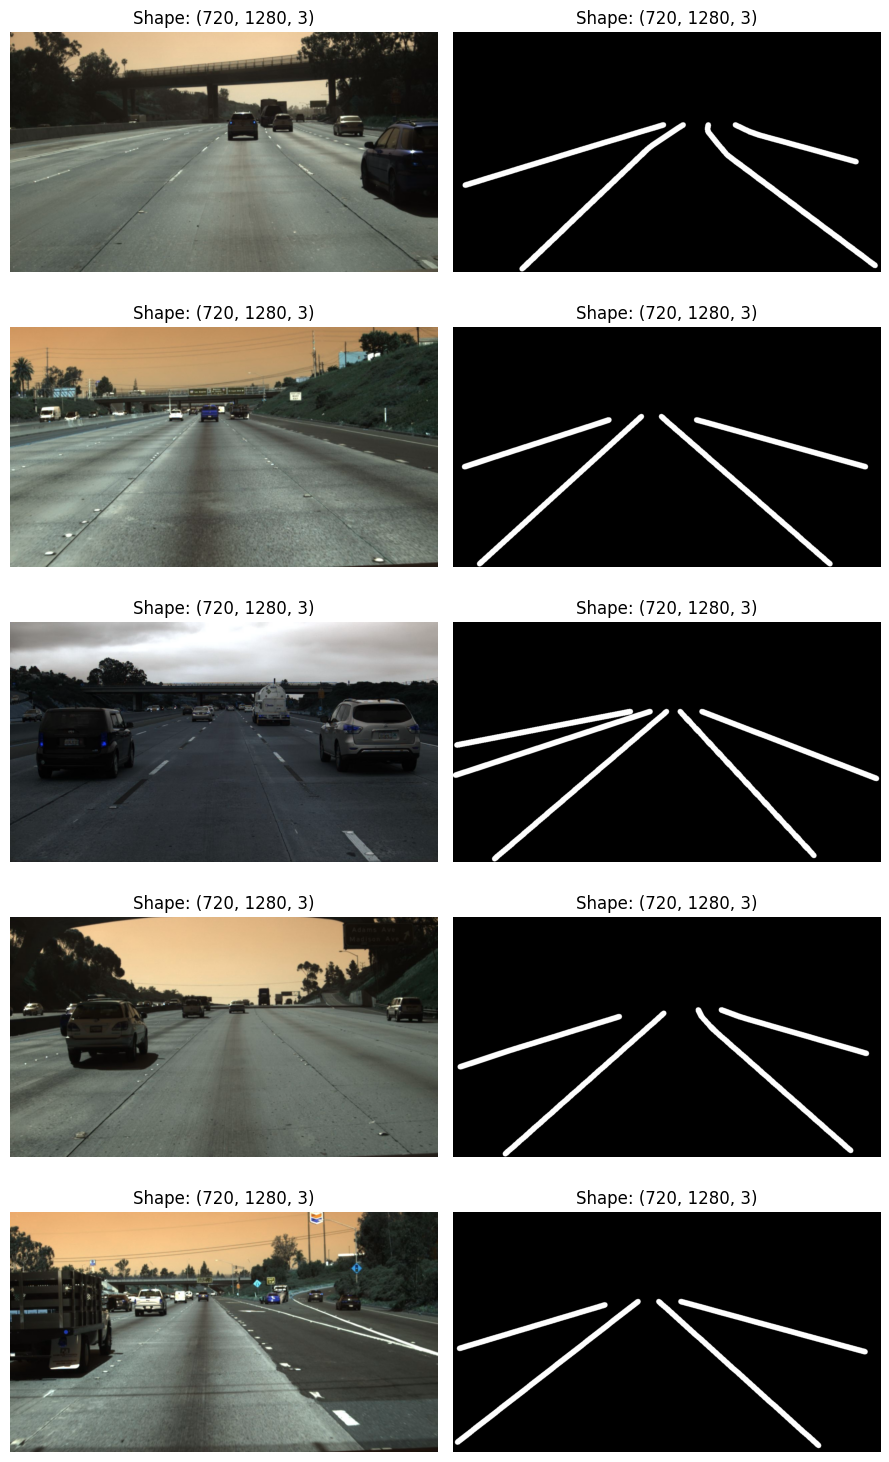

In [4]:
# 5 satir 2 kolonlu bir tablo olusturuyor
fig,ax = plt.subplots(nrows = 5, ncols = 2, figsize = (9,15))
image_indices = list(range(len(IMAGE_PATH_LIST)))
random.shuffle(image_indices)

shuffled_paths = zip([IMAGE_PATH_LIST[i] for i in image_indices], [MASK_PATH_LIST[i] for i in image_indices])

for i,(img_path, mk_path) in enumerate(shuffled_paths):  ## enumerate for ile dizide donerken hem ogeyi hemde indexi almamizi saglar
    if i>4: ## 5 satir olacagi icin ilk 4 index aliniyor
        break
    # Resmi BGR renk uzayında oku
    img_bgr = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # bgr dan rgbye cevirir
    
    ax[i,0].imshow(img_bgr) ## 0 lar image indexi 
    ax[i,0].axis('off')
    ax[i,0].set_title(f'Shape: {img_rgb.shape}')
    
    mask_bgr = cv2.imread(str(mk_path))
    mask_rgb = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2RGB)
    ax[i,1].imshow(mask_rgb) ## 1 ler ise maske
    ax[i,1].axis('off')
    ax[i,1].set_title(f'Shape: {mask_rgb.shape}')

fig.tight_layout()
fig.show()


In [5]:
images_paths = [None] * len(IMAGE_PATH_LIST)
masks_paths = [None] * len(MASK_PATH_LIST)
# resim ve maske yollarindan olusann bir liste olusturduk
for i,(img_path, mask_path) in enumerate(zip(IMAGE_PATH_LIST, MASK_PATH_LIST)): # IMAGE_PATH_LIST ve MASK_PATH_LIST dosya yollarını eşleştirerek döngü oluştur
    images_paths[i] = img_path
    masks_paths[i] = mask_path
    

data = pd.DataFrame({'Image':images_paths, 'Mask':masks_paths}) 
data= data.sample(n=500)
data.reset_index(drop=True, inplace=True)

print(len(data))
data.head()


500


Image  \
0  tusimple_preprocessed2/training/frames/0313-1_...   
1  tusimple_preprocessed2/training/frames/0313-2_...   
2  tusimple_preprocessed2/training/frames/0313-1_...   
3  tusimple_preprocessed2/training/frames/0313-2_...   
4  tusimple_preprocessed2/training/frames/0313-1_...   

                                                Mask  
0  tusimple_preprocessed2/training/lane-masks/031...  
1  tusimple_preprocessed2/training/lane-masks/031...  
2  tusimple_preprocessed2/training/lane-masks/031...  
3  tusimple_preprocessed2/training/lane-masks/031...  
4  tusimple_preprocessed2/training/lane-masks/031...

In [6]:
SEED = 42

data_train, data_rest = train_test_split(data, 
                                         test_size = 0.3, 
                                         random_state = SEED)

data_val, data_test = train_test_split(data_rest, 
                                       test_size = 0.5, 
                                       random_state = SEED)


In [7]:
color2id = {(0, 0, 0): 0, # #b83df5: backgroud
            (255, 255, 255):1, # #ff355e: road_sign
           } 


In [8]:
def mapping_color(img:Image, color2id:dict):
    
    image = np.array(img) ## goruntuler numpy arraylere cevrilir
    
    height,width,_ = image.shape ## uzungluk ve genislik alinir
    output_matrix = np.full(shape = (height, width), fill_value = -1, dtype = np.int32) ## ayni boyutta output matrisi olusturulur ve her bir indexe -1 yazilir
    
    for h in range(height):
        for w in range(width): ## her pixeli donen for dongusu
            color_pixel = tuple(image[h,w,:]) ## pixeli alir
            
            if color_pixel in color2id: ## pixeli bizim color id sozlugumuz ile karsilastirir ve ona gore output matrisine id atamalarini yapar
                output_matrix[h,w] = color2id[color_pixel]
            
    return output_matrix

In [9]:
class CustomDataset(Dataset):
    def __init__(self, data:pd.DataFrame, color2id:dict, image_transforms, mask_transforms):
        self.data = data
        self.color2id = color2id
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        image_path = data.iloc[idx, 0]
        image = Image.open(image_path).convert("RGB")
        image = self.image_transforms(image)
        
        mask_path = data.iloc[idx, 1]
        mask = Image.open(mask_path).convert("RGB")
        mask = self.mask_transforms(mask)
        mask = mapping_color(mask, self.color2id)
    
        return image, mask


In [10]:
RESIZE = (512, 512)

image_transforms = transforms.Compose([transforms.Resize(RESIZE), ## veri setini import eder
                                       transforms.ToTensor()])

mask_transforms = transforms.Compose([transforms.Resize(RESIZE)])

In [11]:
train_dataset = CustomDataset(data_train, 
                              color2id, 
                              image_transforms, 
                              mask_transforms)

val_dataset = CustomDataset(data_val, 
                            color2id, 
                            image_transforms, 
                            mask_transforms)


In [12]:
BATCH_SIZE = 8
NUM_WORKERS = 4

train_dataloader = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = NUM_WORKERS)

val_dataloader = DataLoader(dataset = val_dataset, 
                            batch_size = 1, 
                            shuffle = True, 
                            num_workers = NUM_WORKERS)


In [13]:
batch_images, batch_masks = next(iter(train_dataloader))

batch_images.shape, batch_masks.shape

(torch.Size([8, 3, 512, 512]), torch.Size([8, 512, 512]))

In [14]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [15]:
model = smp.Unet(classes = 2)
model = model.to(DEVICE)

In [16]:
summary(model = model, ## ozetlenecek mode
        col_width = 17, ## tablo stunlarinin genisligi
        input_size = [1,3,512,512], ## modelin girdi boyutu
        col_names = ['input_size','output_size','num_params','trainable'], ## tablo stun isimleri
        row_settings = ['var_names']) ## satir sayilari



Layer (type (var_name))                            Input Shape       Output Shape      Param #           Trainable
Unet (Unet)                                        [1, 3, 512, 512]  [1, 2, 512, 512]  --                True
├─ResNetEncoder (encoder)                          [1, 3, 512, 512]  [1, 3, 512, 512]  --                True
│    └─Conv2d (conv1)                              [1, 3, 512, 512]  [1, 64, 256, 256] 9,408             True
│    └─BatchNorm2d (bn1)                           [1, 64, 256, 256] [1, 64, 256, 256] 128               True
│    └─ReLU (relu)                                 [1, 64, 256, 256] [1, 64, 256, 256] --                --
│    └─MaxPool2d (maxpool)                         [1, 64, 256, 256] [1, 64, 128, 128] --                --
│    └─Sequential (layer1)                         [1, 64, 128, 128] [1, 64, 128, 128] --                True
│    │    └─BasicBlock (0)                         [1, 64, 128, 128] [1, 64, 128, 128] 73,984            True
│    │   

In [17]:
for param in model.encoder.parameters():
    param.requires_grad = False  ## bu kod modelin encoder olarak tanimlanan bolumunu dondurur yani bu bolum egitilmez


In [18]:
summary(model = model, 
        col_width = 17, 
        input_size = [1,3,512,512],
        col_names = ['input_size','output_size','num_params','trainable'], 
        row_settings = ['var_names'])

Layer (type (var_name))                            Input Shape       Output Shape      Param #           Trainable
Unet (Unet)                                        [1, 3, 512, 512]  [1, 2, 512, 512]  --                Partial
├─ResNetEncoder (encoder)                          [1, 3, 512, 512]  [1, 3, 512, 512]  --                False
│    └─Conv2d (conv1)                              [1, 3, 512, 512]  [1, 64, 256, 256] (9,408)           False
│    └─BatchNorm2d (bn1)                           [1, 64, 256, 256] [1, 64, 256, 256] (128)             False
│    └─ReLU (relu)                                 [1, 64, 256, 256] [1, 64, 256, 256] --                --
│    └─MaxPool2d (maxpool)                         [1, 64, 256, 256] [1, 64, 128, 128] --                --
│    └─Sequential (layer1)                         [1, 64, 128, 128] [1, 64, 128, 128] --                False
│    │    └─BasicBlock (0)                         [1, 64, 128, 128] [1, 64, 128, 128] (73,984)          False
│

In [19]:
loss_fn = smp.losses.DiceLoss(mode = "multiclass", classes = 2, ignore_index = -1) ## ignore_index= loss hesaplanirken dikkate alinmayacak olan indexi belirtiyor
optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.0001) ## gradyan inis icin en sik kullanilan algoritmadir. weight_decay parametresi overfitin onune gecmek icin kullanilir
                                                                             ## Yani agin agirliklarinin belirli bir buyuklugu gecmemsini saglar.

In [20]:
class EarlyStopping:
    def __init__(self, patience:int = 3, delta:float = 0.00001, path = "best_model.pth"):
        self.patience = patience ## ne kadar sabirli olacagini belirler
        self.delta = delta ## bu deger modelin iyilesip iyilesmedigini anlamak icin tanimlanir
        self.path = path
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        
    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
            
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

            print(self.counter)
                
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0
            
    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)


In [21]:
# EarlyStopping
early_stopping = EarlyStopping(patience=5, delta=0.)

In [22]:
def train_step(model:torch.nn.Module, dataloader:torch.utils.data.DataLoader, 
               loss_fn:smp.losses, optimizer:torch.optim.Optimizer):
    
    model.train() ## model egitim moduna gecer
    
    train_loss = 0.
    train_iou = 0.
    
    for batch,(X,y) in enumerate(dataloader):
        X = X.to(device = DEVICE, dtype = torch.float32) ## giris verisi ve 
        y = y.to(device = DEVICE, dtype = torch.long)    ## hedef verisi alinir
        
        optimizer.zero_grad() ## optimizerin gradyanlarini sifirlar
        
        pred_logit = model(X) ## giris verisi ile modelin tahminlerini alir
        loss = loss_fn(pred_logit, y) ## tahmin edilenlerle gercek etiketleri karsilastirir ve loss hesaplanir
        train_loss = loss.item()
        
        loss.backward() ## geriye dogru gecis yaparak gradyanlari hesaplar
        optimizer.step()## optimizeri bir adim daha iler goturerek model parametresini gunceller
        
        pred_prob = pred_logit.softmax(dim = 1)
        pred_class = pred_prob.argmax(dim = 1) ## bu arkadaslar modelin ciktilarini olasilik dagilimina donusturur ve en yuksek olasiliga sahip sinifi secer
        
        tp,fp,fn,tn = smp.metrics.get_stats(output = pred_class.detach().to(DEVICE).long(), 
                                            target = y.to(DEVICE), 
                                            mode = "multiclass", 
                                            ignore_index = -1, 
                                            num_classes = 2)
        
        train_iou += smp.metrics.iou_score(tp, fp, fn, tn, reduction = "micro")
        
    train_loss = train_loss / len(dataloader)
    train_iou = train_iou / len(dataloader)
    
    return train_loss, train_iou

In [23]:
def val_step(model:torch.nn.Module, dataloader:torch.utils.data.DataLoader, 
             loss_fn:smp.losses):
    
    model.eval()
    
    val_loss = 0.
    val_iou = 0.
    
    with torch.inference_mode():
    
        for batch,(X,y) in enumerate(dataloader):
            X = X.to(device = DEVICE, dtype = torch.float32)
            y = y.to(device = DEVICE, dtype = torch.long)

            pred_logit = model(X)
            loss = loss_fn(pred_logit, y)
            val_loss = loss.item()

            pred_prob = pred_logit.softmax(dim = 1)
            pred_class = pred_prob.argmax(dim = 1)

            tp,fp,fn,tn = smp.metrics.get_stats(output = pred_class.detach().to(DEVICE).long(), 
                                                target = y.to(DEVICE), 
                                                mode = "multiclass", 
                                                ignore_index = -1, 
                                                num_classes = 2)

            val_iou += smp.metrics.iou_score(tp, fp, fn, tn, reduction = "micro")
        
        
    val_loss = val_loss / len(dataloader)
    val_iou = val_iou / len(dataloader)
    
    return val_loss, val_iou


In [24]:
def train(model:torch.nn.Module, train_dataloader:torch.utils.data.DataLoader, 
          val_dataloader:torch.utils.data.DataLoader, loss_fn:torch.nn.Module, optimizer:torch.optim.Optimizer, 
          early_stopping, epochs:int = 10):
    
    results = {'train_loss':[], 'train_iou':[], 'val_loss':[], 'val_iou':[]}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_iou = train_step(model = model, 
                                           dataloader = train_dataloader, 
                                           loss_fn = loss_fn, 
                                           optimizer = optimizer)
        
        val_loss, val_iou = val_step(model = model, 
                                     dataloader = val_dataloader, 
                                     loss_fn = loss_fn)
        
        print(f'Epoch: {epoch + 1} | ', 
              f'Train Loss: {train_loss:.4f} | ', 
              f'Train IOU: {train_iou:.4f} | ', 
              f'Val Loss: {val_loss:.4f} | ', 
              f'Val IOU: {val_iou:.4f}')
        
        
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop == True:
            print("Early Stopping!!")
            break
            
        results['train_loss'].append(train_loss)
        results['train_iou'].append(train_iou)
        results['val_loss'].append(val_loss)
        results['val_iou'].append(val_iou)
        
    return results

In [25]:
# Training!!!
EPOCHS = 200

torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

RESULTS = train(model.to(device = DEVICE), 
                train_dataloader, 
                val_dataloader, 
                loss_fn, 
                optimizer, 
                early_stopping, 
                EPOCHS)


  0%|          | 1/200 [02:41<8:54:15, 161.09s/it]

Epoch: 1 |  Train Loss: 0.0060 |  Train IOU: 0.9093 |  Val Loss: 0.0047 |  Val IOU: 0.9623


  1%|          | 2/200 [05:24<8:56:44, 162.65s/it]

Epoch: 2 |  Train Loss: 0.0049 |  Train IOU: 0.9618 |  Val Loss: 0.0047 |  Val IOU: 0.9620


  2%|▏         | 3/200 [08:09<8:56:55, 163.53s/it]

Epoch: 3 |  Train Loss: 0.0039 |  Train IOU: 0.9660 |  Val Loss: 0.0020 |  Val IOU: 0.9682


  2%|▏         | 4/200 [10:51<8:52:56, 163.15s/it]

Epoch: 4 |  Train Loss: 0.0041 |  Train IOU: 0.9690 |  Val Loss: 0.0014 |  Val IOU: 0.9704


  2%|▎         | 5/200 [13:38<8:53:40, 164.21s/it]

Epoch: 5 |  Train Loss: 0.0036 |  Train IOU: 0.9711 |  Val Loss: 0.0028 |  Val IOU: 0.9720
1


  3%|▎         | 6/200 [16:19<8:47:51, 163.25s/it]

Epoch: 6 |  Train Loss: 0.0031 |  Train IOU: 0.9724 |  Val Loss: 0.0026 |  Val IOU: 0.9739
2


  4%|▎         | 7/200 [19:00<8:42:56, 162.57s/it]

Epoch: 7 |  Train Loss: 0.0028 |  Train IOU: 0.9735 |  Val Loss: 0.0021 |  Val IOU: 0.9738
3


  4%|▍         | 8/200 [21:41<8:38:41, 162.09s/it]

Epoch: 8 |  Train Loss: 0.0044 |  Train IOU: 0.9746 |  Val Loss: 0.0011 |  Val IOU: 0.9755


  4%|▍         | 9/200 [24:23<8:35:50, 162.05s/it]

Epoch: 9 |  Train Loss: 0.0034 |  Train IOU: 0.9750 |  Val Loss: 0.0017 |  Val IOU: 0.9751
1


  5%|▌         | 10/200 [27:04<8:32:16, 161.77s/it]

Epoch: 10 |  Train Loss: 0.0030 |  Train IOU: 0.9759 |  Val Loss: 0.0008 |  Val IOU: 0.9760


  6%|▌         | 11/200 [29:44<8:27:55, 161.25s/it]

Epoch: 11 |  Train Loss: 0.0026 |  Train IOU: 0.9758 |  Val Loss: 0.0025 |  Val IOU: 0.9765
1


  6%|▌         | 12/200 [32:26<8:25:10, 161.22s/it]

Epoch: 12 |  Train Loss: 0.0032 |  Train IOU: 0.9770 |  Val Loss: 0.0017 |  Val IOU: 0.9760
2


  6%|▋         | 13/200 [35:07<8:22:36, 161.27s/it]

Epoch: 13 |  Train Loss: 0.0032 |  Train IOU: 0.9770 |  Val Loss: 0.0009 |  Val IOU: 0.9768
3


  7%|▋         | 14/200 [37:49<8:20:25, 161.43s/it]

Epoch: 14 |  Train Loss: 0.0031 |  Train IOU: 0.9774 |  Val Loss: 0.0020 |  Val IOU: 0.9752
4


  7%|▋         | 14/200 [40:30<8:58:12, 173.61s/it]

Epoch: 15 |  Train Loss: 0.0030 |  Train IOU: 0.9777 |  Val Loss: 0.0025 |  Val IOU: 0.9768
5
Early Stopping!!


In [48]:
def loss_and_metric_plot(results:dict):
    training_loss = results['train_loss']
    valid_loss = results['val_loss']
    
    training_iou = results['train_iou']
    valid_iou = results['val_iou']
    
    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))
    axes = axes.flat
    
    axes[0].plot(range(len(training_loss)), training_loss)
    axes[0].plot(range(len(valid_loss)), valid_loss)
    axes[0].set_xlabel("Epoch", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_ylabel("Loss", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_title("Dice Loss", fontsize = 14, fontweight = "bold", color = "blue")
    
    axes[1].plot(range(len(training_iou)), training_iou)
    axes[1].plot(range(len(valid_iou)), valid_iou)
    axes[1].set_xlabel("Epoch", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_ylabel("score", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_title("IOU", fontsize = 14, fontweight = "bold", color = "red")
    
    fig.tight_layout()
    fig.show()

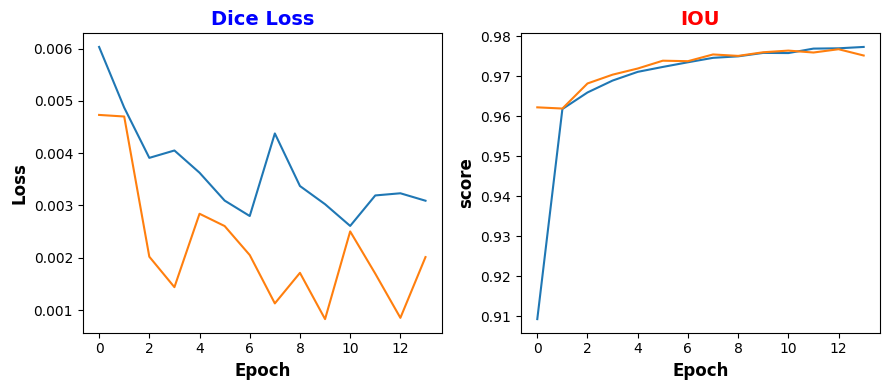

In [49]:
loss_and_metric_plot(RESULTS)

In [38]:
def predictions(test_dataloader:torch.utils.data.DataLoader, best_model:str):
    
    checkpoint = torch.load(best_model)
    
    loaded_model = smp.Unet(encoder_name = "resnet34", encoder_weights = None, classes = 2)

    loaded_model.load_state_dict(checkpoint)

    loaded_model.to(device = DEVICE)

    loaded_model.eval()

    pred_mask_test = []

    with torch.inference_mode():
        for X,_ in tqdm(test_dataloader):
            X = X.to(device = DEVICE, dtype = torch.float32)
            logit_mask = loaded_model(X)
            prob_mask = logit_mask.softmax(dim = 1)
            pred_mask = prob_mask.argmax(dim = 1)
            pred_mask_test.append(pred_mask.detach().cpu())

    pred_mask_test = torch.cat(pred_mask_test)

    return pred_mask_test


In [39]:
test_dataset = CustomDataset(data_test, color2id, image_transforms, mask_transforms)

test_dataloader = DataLoader(dataset = test_dataset, 
                             batch_size = BATCH_SIZE, 
                             shuffle = False)


In [40]:
pred_mask_test = predictions(test_dataloader, "best_model.pth")

100%|██████████| 10/10 [01:27<00:00,  8.72s/it]


In [41]:
IMAGE_TEST = []
MASK_TEST = []

for img,mask in test_dataloader:
    IMAGE_TEST.append(img)
    MASK_TEST.append(mask)

IMAGE_TEST = torch.cat(IMAGE_TEST)

MASK_TEST = torch.cat(MASK_TEST)


In [42]:
TP, FP, FN, TN = smp.metrics.get_stats(output = pred_mask_test.long(), 
                                       target = MASK_TEST.long(), 
                                       mode = "multiclass", 
                                       ignore_index = -1, 
                                       num_classes = 2)

In [43]:
iou_test = smp.metrics.iou_score(TP, FP, FN, TN, reduction = "micro")
print(f'IOU Test = {iou_test:.4f}')

IOU Test = 0.9760


In [44]:
id2color = {0: (0, 0, 0), # background
            1: (255, 255, 255), # road_sign
           } # road_surface


In [45]:
total_mask_output = []

for i,mask_pred in enumerate(pred_mask_test):
    
    # We extract the height and width of the mask.
    height,width = mask_pred.shape
    
    # We are going to create a Boolean array to filter the values -1, which is that id that does not belong to any class.
    mask_original = MASK_TEST[i]
    ignore = mask_original == -1 # id: -1
    
    mask_predicted = torch.where(ignore, -1, mask_pred)
    mask_zeros = torch.zeros(size = (height, width, 3), dtype = torch.uint8)
    
    for h in range(height):
        for w in range(width):
            idcolor = int(mask_predicted[h,w])
            
            if idcolor in id2color:
                mask_zeros[h,w,:] = torch.tensor(id2color[idcolor])
    
    total_mask_output.append(mask_zeros)


In [46]:
total_mask_test = []

for mask_tst in MASK_TEST:
    
    # Extraemos el height y width de la máscara.
    height,width = mask_tst.shape
    
    mask_zeros = torch.zeros(size = (height, width, 3), dtype = torch.uint8)
    
    for h in range(height):
        for w in range(width):
            idcolor = int(mask_tst[h,w])
            
            if idcolor in id2color:
                mask_zeros[h,w,:] = torch.tensor(id2color[idcolor])
    
    total_mask_test.append(mask_zeros)

75


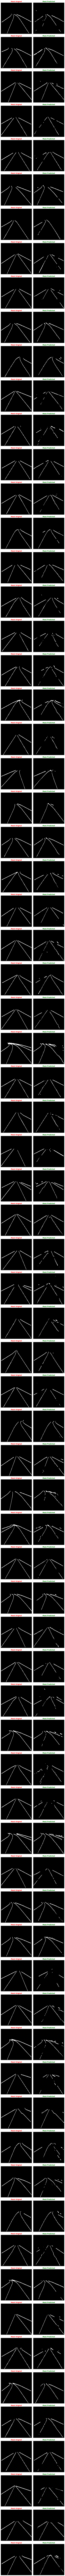

In [56]:
# Finally, we visualize the predicted mask and the actual mask.
fig, ax = plt.subplots(nrows=len(total_mask_test), ncols=2, figsize=(8, 4 * len(total_mask_test)))
print(len(total_mask_test))
for i,(mk_out,mk_test) in enumerate(zip(total_mask_output, total_mask_test)):
    
    mask_test = mk_test.numpy()
    ax[i,0].imshow(mask_test)
    ax[i,0].set_title("Mask Original", fontsize = 12, fontweight = "bold", color = "red")
    ax[i,0].axis('off')
    
    mask_out = mk_out.numpy()
    ax[i,1].imshow(mask_out)
    ax[i,1].set_title("Mask Predicted", fontsize = 12, fontweight = "bold", color = "green")
    ax[i,1].axis('off')
    
fig.tight_layout()
fig.show()
